In [34]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random
from sklearn.metrics import classification_report


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


In [35]:
train = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Train_Dataset.csv")
test = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Test_Dataset.csv")
val = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Val_Dataset.csv")

In [36]:
def get_tweet(data):
    tweets = data['text']
    labels = data['label']
    labels = labels.replace(["0","1","2","3","4","5"],['sadness','joy','love','anger','fear','surprise'])
    return tweets, labels

In [37]:
tweets, labels = get_tweet(train)

In [38]:
print(labels)

0            joy
1           fear
2          anger
3        sadness
4            joy
          ...   
19458    sadness
19459    sadness
19460        joy
19461      anger
19462    sadness
Name: label, Length: 19463, dtype: object


In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [40]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [41]:
tokenizer.texts_to_sequences([tweets[1]])

[[168, 45, 2, 946, 10, 136, 2, 89, 38, 2, 83, 1213, 7, 1241, 1145, 80, 344]]

In [42]:
tweets[1]

'Every time I imagine that someone I love or I could contact a serious illness, even death.'

<function matplotlib.pyplot.show(close=None, block=None)>

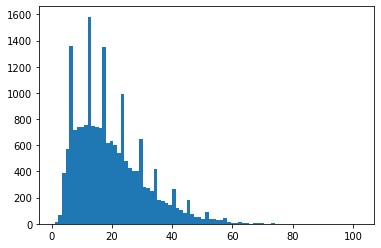

In [43]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show

In [44]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [45]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlen)
  return padded

In [46]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [47]:
padded_train_seq

array([[ 30, 157,  17, ...,   0,   0,   0],
       [168,  45,   2, ...,   0,   0,   0],
       [ 17,   2,  32, ...,   0,   0,   0],
       ...,
       [  2,   4, 370, ...,   0,   0,   0],
       [  2,   4,  18, ...,   0,   0,   0],
       [  2,  53,   7, ...,   0,   0,   0]])

In [48]:
#classes = set(labels)
classes = ['joy', 'fear', 'anger', 'sadness', 'love', 'surprise']
print(classes)

['joy', 'fear', 'anger', 'sadness', 'love', 'surprise']


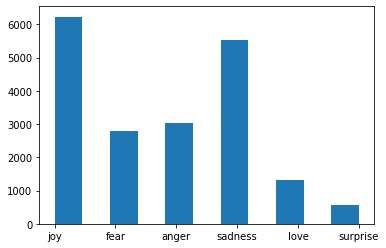

In [49]:
plt.hist(labels, bins=11)
plt.show()

In [50]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [51]:
class_to_index

{'joy': 0, 'fear': 1, 'anger': 2, 'sadness': 3, 'love': 4, 'surprise': 5}

In [52]:
index_to_class

{0: 'joy', 1: 'fear', 2: 'anger', 3: 'sadness', 4: 'love', 5: 'surprise'}

In [53]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [54]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


In [61]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.SimpleRNN(20, return_sequences=True),
        tf.keras.layers.SimpleRNN(20),
        tf.keras.layers.Dropout(.25, input_shape=(2,)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 20)            740       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
Total params: 161,686
Trainable params: 161,686
Non-trainable params: 0
_________________________________________________________________


In [63]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [64]:
val_tweets[0], val_labels[0]

('The news of the natural calamity, an earthquake in which hundreds of Mexican people died.',
 3)

In [65]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
609/609 [==============================] - 140s 227ms/step - loss: 1.5947 - accuracy: 0.3255 - val_loss: 1.4506 - val_accuracy: 0.4353
Epoch 2/20
609/609 [==============================] - 148s 243ms/step - loss: 1.3070 - accuracy: 0.5203 - val_loss: 1.3022 - val_accuracy: 0.5360
Epoch 3/20
609/609 [==============================] - 141s 231ms/step - loss: 1.0314 - accuracy: 0.6474 - val_loss: 1.2785 - val_accuracy: 0.5467
Epoch 4/20
609/609 [==============================] - 166s 272ms/step - loss: 0.8508 - accuracy: 0.7169 - val_loss: 1.2819 - val_accuracy: 0.5516
Epoch 5/20
609/609 [==============================] - 174s 285ms/step - loss: 0.7019 - accuracy: 0.7671 - val_loss: 1.4011 - val_accuracy: 0.5606
Epoch 6/20
609/609 [==============================] - 177s 291ms/step - loss: 0.5971 - accuracy: 0.8071 - val_loss: 1.5026 - val_accuracy: 0.5475
Epoch 7/20
609/609 [==============================] - 173s 285ms/step - loss: 0.5153 - accuracy: 0.8319 - val_loss: 1.5985 -

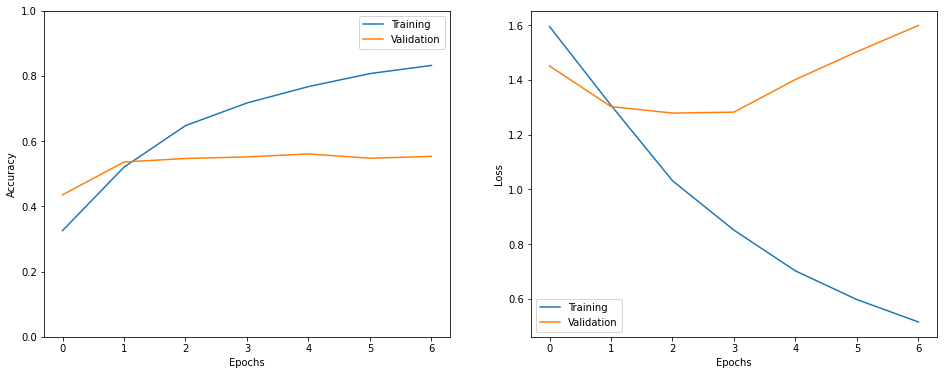

In [66]:
show_history(h)

In [67]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [68]:
_=model.evaluate(test_seq, test_labels)

77/77 [==============================] - 2s 25ms/step - loss: 1.6003 - accuracy: 0.5479


In [69]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i do take on a half marathon challenge then i will wait and see how the body feels as to whether there will be a pb attempt or a casual kilometre shuffle
Emotion: joy
Predicted Emotion: joy


In [70]:
preds = np.argmax(model.predict(test_seq), axis=-1)

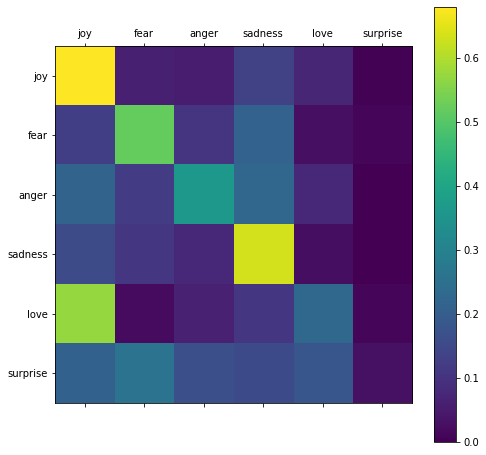

In [71]:
show_confusion_matrix(test_labels, preds, list(classes))

In [72]:
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65       808
           1       0.47      0.52      0.49       326
           2       0.47      0.36      0.41       380
           3       0.60      0.63      0.62       694
           4       0.22      0.23      0.23       159
           5       0.18      0.03      0.05        66

    accuracy                           0.55      2433
   macro avg       0.43      0.41      0.41      2433
weighted avg       0.54      0.55      0.54      2433



In [33]:
from datetime import datetime
model.save("C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model/SA_Model_Alt_v1")

INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model/SA_Model_Alt_v1\assets


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model/SA_Model_Alt_v1\assets
